In [1]:
#importing the needed libraries
import numpy as np
import matplotlib.pyplot as plt

#to install celluloid: pip install celluloid
from celluloid import Camera  

In [2]:
#planet's mass
M_J = 1.899*10**30 #g

#planet's distance from star (semi major axis)
r_J = 1.496*10**15 #cm

#star's mass
M_star = 10**33 #g

#gravity constant
G = 6.67*10**(-8)  #cm^3g^−1s^−2

#planet's orbital period calculated using kepler's 3rd law
T = np.sqrt(((4*(np.pi**2)) / (G*(M_star + M_J)))*r_J**3)

#prints the orbital period in years
print("Orbital Period:", round(T/3.154e+7,2) , "yrs.")

Orbital Period: 1410.07 yrs.


In [3]:
#Initial values for planet before integration scheme 

#initial x and y values
x0 = 0 #cm
y0 = r_J #cm
ri2 = x0**2 + y0**2 

#initial position vector
r0 = np.array([x0,y0]) #cm

#initial velocity vector
v0 = np.array([np.sqrt(((G*M_star)/(r_J))),0.]) #cm/s
#velocity components
dx0 = v0[0]
dy0 = v0[1]

#initial acceleration vector
a0 = np.array([(-G*M_star/(ri2))*(x0/(np.sqrt(ri2))),(-G*M_star/(ri2))*(y0/(np.sqrt(ri2)))]) #cm/s^2

#intial jolt vector
da0 = np.array([-G*M_star*((dx0/((ri2)**(3/2))) + 3*((np.dot(v0,r0)*x0)/((ri2)**(5/2)))),
                           -G*M_star*((dy0/((ri2)**(3/2))) + 3*((np.dot(v0,r0)*y0)/((ri2)**(5/2))))]) #cm/s^3

In [4]:
#Initial values for host star before integration scheme 

#initial position vector placing star at the origin
r1 = np.array([0.,0.]) #cm

#assuming velocity rounds to zero
v1 = np.array([0.,0.]) #cm/s
#velocity components
dx1 = v1[0]
dy1 = v1[1]

#inital acceleration vector
a1 = np.array([0,(G*M_J/(r_J**2))]) #cm/s^2

#initial jolt vector
da1 = np.array([-G*M_J*((dx1/((ri2)**(3/2))) + 3*((np.dot(v0,-r0)*x0)/((ri2)**(5/2)))),
                           -G*M_J*((dy1/((ri2)**(3/2))) + 3*((np.dot(v0,-r0)*-y0)/((ri2)**(5/2))))]) #cm/s^3

#checking if forces are equal
print("Checking Forces are Equal:")
print("F1 = ", '%.8g' % abs(a1[1]*M_star), "dyne")
print("F0 = ", '%.8g' % abs(a0[1]*M_J), "dyne")

Checking Forces are Equal:
F1 =  5.6596244e+25 dyne
F0 =  5.6596244e+25 dyne


In [5]:
#Initial values for third body star before integration scheme 

#x and y coordinates 
x_star = 1.496e+16*1.11 #cm
y_star = -1.496e+16 #cm

#star's mass 
m_star = M_star

#initial position vector
r_star = np.array([x_star, y_star]) #cm

#initial velocity vector, assume constant velocity 
v_star = np.array([0, 100000]) #cm/s
#velocity components
dx_star = v_star[0]
dy_star = v_star[1]

#initial acceleration vector, round down to zero
a_star = np.array([0,0]) #cm/s^2

#initial jolt vector, round down to zero
da_star = np.array([0,0]) #cm/s^3


In [6]:
#Initial Energies

#kinetic energy of planet 
KEi_planet = (1/2)*M_J*(np.linalg.norm(v0)**2)

#kinetic energy of star 1:
KEi_star1 = (1/2)*M_star*(np.linalg.norm(v1)**2)

#kinetic energy of star 2: 
KEi_star2 = (1/2)*m_star*(np.linalg.norm(v_star)**2)

#potential energy between planet and star 1
Ui_planet = G*M_star*M_J / np.linalg.norm(r0)**2

#potential energy between planet and star 2
Ui_planet2 = G*m_star*M_J / ((np.linalg.norm(r_star - r0))**2)

#potential energy between star 1 and star 2
Ui_stars = G*M_star*m_star / (np.linalg.norm(r_star)**2)

#total intial energy for the single planet system without the third body 
Ei_total1 = KEi_planet + KEi_star1 + Ui_planet 

#total intial energy for the three body system
Ei_total = KEi_planet + KEi_star1 + KEi_star2 + Ui_planet + Ui_planet2 + Ui_stars

In [7]:
#adds initial values to lists 
r_all = [r0,r1,r_star]
v_all = [v0,v1,v_star]
a_all = [a0,a1,a_star]
da_all = [da0,da1,da_star]
m_all = [M_J,M_star,m_star]

In [8]:
def Nbody_Hermite(m_all, r_all, v_all, a_all, da_all, dt, tmax, N): 
    '''
    An N body gravity code that uses a 4th Order Hermite Integration Scheme to calculate the position, velocity, and 
    acceleration of each body in the system through various steps in a total time when given mass values and inital
    values for the position, velocity, acceleration and jolt of each body at t = 0s. 
    
    Parameters:
    ----------
    m_all: list [float]
            A list of the masses in grams of each body in the system.
    
    r_all: list [1D float array]
           A list of the position vectors in cm (measured from the origin in cartesian coordinates) of each body in 
           the system at t = 0s
    
    v_all: list [1D float array]
            A list of the velocity vectors in cm/s (measured from the origin in cartesian coordinates) of each body 
            in the system at t = 0s.
    
    a_all: list [1D float array]
           A list of the acceleration vectors in cm/s**2 (measured from the origin in cartesian coordinates) of each 
           body in the system at t = 0s.
           
    da_all: list [1D float array]
            A list of the jolt vectors in cm/s**3 (measured from the origin in cartesian coordinates) of each body 
            in the system at t = 0s.
    
    dt: number (float or integer)
        The amount of time (timestep) in seconds added to the starting time at each step of the loop. 
        For the function to work properly, this value needs to be carefully chosen based on the initial data of 
        the system. 
    
    tmax: number (float or integer)
          The maximum amount of time in seconds. The loop runs while the time is less than this value. 
    
    N: integer
       The total number of bodies in the system.
    
    Returns:
    -------
    x_time: array
            An N by int(tmax/dt)+1 array of the x positions in cm of each body in the system at each step. 
    
    y_time: array
            An N by int(tmax/dt)+1 array of the y positions in cm of each body in the system at each step. 
    
    vx_time: array
             An N by int(tmax/dt)+1 array of the x components of velocity in cm/s of each body in the system 
             at each step. 
    
    vy_time: array
             An N by int(tmax/dt)+1 array of the y components of velocity in cm/s of each body in the system 
             at each step. 
    
    '''
    #sets count and time to be zero before the loop 
    count = 0 
    ti = 0
    
    #gravity constant
    G = 6.67*10**(-8)  #cm^3g^−1s^−2
    
    #empty lists for position and velocity values
    r_ti_all = []
    v_ti_all = []
    
    #empty lists for new acceleration and jolt values
    a_sums = [[]]*N
    da_sums = [[]]*N
    
    #empty lists for old acceleration and jolt values
    a_old = []
    da_old = []
    
    #empty arrays for all position and velocity values
    x_time = np.empty((N,int(tmax/dt + 1)))
    y_time = np.empty((N,int(tmax/dt + 1)))
    vx_time = np.empty((N,int(tmax/dt + 1)))
    vy_time = np.empty((N,int(tmax/dt + 1)))
    
    #4th order hermite integration scheme loop
    while ti < tmax : 
        
        #adds timestep, dt to current time, ti each loop
        ti = ti + dt
        
        #reseting the following lists as zero each loop 
        
        #empty lists for position and velocity prediction values
        rip_all = []
        vip_all = []
        
        #empty lists for 2nd and 3rd derivative of acceleration values
        d2a0_all = []
        d3a0_all = []
        
        #empty lists for old acceleration and jolt values
        a_old = []
        da_old = []
        
        #loop that goes through each body in the N body system 
        for i in range(0,N):
            
            #sets values at current timestep for body i
            if count == 0: 
                ri = r_all[i]
                vi = v_all[i]
                ai = a_all[i]
                dai = da_all[i]
                
                x_time[i,count] = ri[0]
                y_time[i,count] = ri[1]
                vx_time[i,count] = vi[0]
                vy_time[i,count] = vi[1]
            
            else:
                ri = r_ti_all[i]
                vi = v_ti_all[i]
                ai = a_sums[i]
                dai = da_sums[i]
            
            #sets acceleration and jolt to be zero
            a = 0
            da = 0
            
            #calculates position and velocity prediction for body i
            rip = ri + vi*(dt) + 0.5*ai*(dt)**2 + (1/6)*dai*(dt)**3
            vip = vi + ai*(dt) + 0.5*dai*(dt)**2
            
            #adds position and velocity prediction to lists
            rip_all.append(rip)
            vip_all.append(vip)
            
            #loop that goes through each body in the N body system 
            for j in range (0,N):
                
                #calculations below only runs if body j is different than body i
                if i != j: 
                    
                    #sets values at current timestep for body j
                    if count == 0: 
                        rj = r_all[j]
                        vj = v_all[j]
                        aj = a_all[j]
                        daj = da_all[j]
                    
                    else: 
                        rj = r_ti_all[j]
                        vj = v_ti_all[j]
                        aj = a_sums[j]
                        daj = da_sums[j]   
                        
                    #calculates position and velocity prediction for body j 
                    rjp = rj + vj*(dt) + 0.5*aj*(dt**2) + (1/6)*daj*(dt**3)
                    vjp = vj + aj*(dt) + 0.5*daj*(dt**2) 
                    
                    #calculates distance between the two bodies
                    rij = rjp - rip
                    
                    #calculates velocity of body i relative to j
                    vij = vjp - vip 
                    
                    #summation calculation of the acceleration and jolt of body i 
                    a = a + (G*m_all[j]*rij) / ((np.linalg.norm(rij)**2)**(3/2))
                    da = da + G*m_all[j]*((vij/((np.linalg.norm(rij))**2)**(3/2)) + 3*(np.dot(vij,rij)*rij)/
                                      ((np.linalg.norm(rij)**2)**(5/2)))
            
            #adds acceleration and jolt values from last time value to a list
            if count > 0 :
                a_old.append(a_sums[i])
                da_old.append(da_sums[i])
            else: 
                a_old.append(a_all[i])
                da_old.append(da_all[i])
            
            #updates current acceleration and jolts to lists 
            a_sums[i] = a
            da_sums[i] = da
        
        #clears past position and acceleration values
        r_ti_all = []
        v_ti_all = []
        
        #adds 1 to count total
        count = count + 1
        
        #loop that goes through each body in the N body system 
        for i in range(0,N):
            
            #calculates current acceleration derivatives for body i
            d2a0 = (-6*(a_old[i] - a_sums[i]) - dt*(4*da_old[i] + 2*da_sums[i])) / dt**2
            d3a0 = (12*(a_old[i] - a_sums[i]) + 6*dt*(da_old[i] + da_sums[i])) / dt**3
            
            #calculates position and velocity correction values for body i 
            r_ti = rip_all[i] + ((dt**4)/24)*d2a0 + ((dt**5)/120)*d3a0
            v_ti = vip_all[i] + ((dt**3)/6)*d2a0 + ((dt**4)/24)*d3a0
            
            #adds correction values to lists and arrays      
            r_ti_all.append(r_ti)
            v_ti_all.append(v_ti)
            
            x_time[i,count] = r_ti[0]
            y_time[i,count] = r_ti[1]
            
            vx_time[i,count] = v_ti[0]
            vy_time[i,count] = v_ti[1]
        
    #returns all positions and velocities at each step
    return [x_time, y_time, vx_time, vy_time]

In [9]:
#good integration timestep based on planet's orbital period, (not just any timestep will work properly)
dt = T/10000

#uses 4th order hermite integration scheme to simulate a single planet system for about one orbit
sim_data = Nbody_Hermite(m_all, r_all, v_all, a_all, da_all, dt, T, 2)

#uses 4th order hermite integration scheme to simulate the evolution of a
#single planet system that is subject to an external perturbation due to a passing star
sim_data2 = Nbody_Hermite(m_all, r_all, v_all, a_all, da_all, dt, 8*T, 3)

In [10]:
#Final energy calculation for the single planet system 

#planet - star 1 final distance
rf_planet_star1  = np.sqrt((sim_data[0][0,-1] - sim_data[0][1,-1])**2 + (sim_data[1][0,-1] - sim_data[1][1,-1])**2)

#planet final velocity squared
v2_planet = sim_data[2][0,-1]**2 + sim_data[3][0,-1]**2

#star 1 final velocity squared
v2_star1 = sim_data[2][1,-1]**2 + sim_data[3][1,-1]**2

#kinetic energy of planet 
KEf_planet = (1/2)*M_J*(v2_planet)

#kinetic energy of star 1:
KEf_star1 = (1/2)*M_star*(v2_star1)

#potential energy between planet and star 1
Uf_planet = G*M_star*M_J / ((rf_planet_star1)**2)

#total final energy 
Ef_total1 = KEf_planet + KEf_star1 + Uf_planet 

#prints initial and final energy 
print("Initial Energy:", Ei_total1, "ergs")
print("Final Energy:", Ef_total1, "ergs")

#calculatng and printing the percent difference between the initial and final energy
diff1 = (abs(Ei_total1 - Ef_total1) / ((Ei_total1 + Ef_total1)/2))*100
print("Percent difference:", diff1, "%")

#they are conserved to a reasonable degree if their difference is within: 
e = 25 #%

#checking if energy is conserved reasonably 
if diff1 < e:
    print("Energy is conserved.")
else: 
    print("Energy is not conserved.")

Initial Energy: 4.233399064171128e+40 ergs
Final Energy: 4.233401612439033e+40 ergs
Percent difference: 6.019435209506839e-05 %
Energy is conserved.


In [11]:
#Final energy calculation for the single planet system that is subject to an external perturbation 
#due to a passing star

#planet - star 1 final distance
rf_planet_star1  = np.sqrt((sim_data2[0][0,-1] - sim_data2[0][1,-1])**2 + (sim_data2[1][0,-1] - sim_data2[1][1,-1])**2)

#planet - star 2 final distance 
rf_planet_star2 = np.sqrt((sim_data2[0][0,-1] - sim_data2[0][2,-1])**2 + (sim_data2[1][0,-1] - sim_data2[1][2,-1])**2)

#star 1- star 2 final distance 
rf_star1_star2 = np.sqrt((sim_data2[0][1,-1] - sim_data2[0][2,-1])**2 + (sim_data2[1][1,-1] - sim_data2[1][2,-1])**2)

#planet final velocity squared
v2_planet = sim_data2[2][0,-1]**2 + sim_data2[3][0,-1]**2

#star 1 final velocity squared
v2_star1 = sim_data2[2][1,-1]**2 + sim_data2[3][1,-1]**2

#star 2 final velocity squared
v2_star2 = sim_data2[2][2,-1]**2 + sim_data2[3][2,-1]**2

#kinetic energy of planet 
KEf_planet = (1/2)*M_J*(v2_planet)

#kinetic energy of star 1:
KEf_star1 = (1/2)*M_star*(v2_star1)

#kinetic energy of star 2: 
KEf_star2 = (1/2)*m_star*(v2_star2)

#potential energy between planet and star 1
Uf_planet = G*M_star*M_J / ((rf_planet_star1)**2)

#potential energy between planet and star 2
Uf_planet2 = G*m_star*M_J / ((rf_planet_star2)**2)

#potential energy between star 1 and star 2
Uf_stars = G*M_star*m_star / ((rf_star1_star2)**2)

#total final energy 
Ef_total = KEf_planet + KEf_star1 + KEf_star2 + Uf_planet + Uf_planet2 + Uf_stars

#prints initial and final energy
print("Initial Energy:", Ei_total, "ergs")
print("Final Energy:", Ef_total, "ergs")

#calculatng and printing the percent difference between the initial and final energy
diff = (abs(Ei_total - Ef_total) / ((Ei_total + Ef_total)/2))*100
print("Percent difference:", diff, "%")

#they are conserved to a reasonable degree is their difference is within: 
e = 25 #%

#checking if energy is conserved reasonably 
if diff < e:
    print("Energy is conserved.")
else: 
    print("Energy is not conserved.")

Initial Energy: 5.042333990641711e+42 ergs
Final Energy: 5.902153122890578e+42 ergs
Percent difference: 15.712369585336639 %
Energy is conserved.


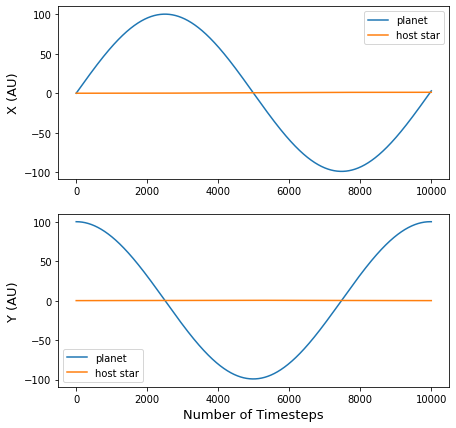

In [12]:
#conversion to AU from cm
AU = 1.49598073e+13 #cm

#plotting and labelling the positions of the single planet system over time
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(7)

axs[0].plot(sim_data[0][0,:]/AU, label = 'planet')
axs[0].plot(sim_data[0][1,:]/AU, label = 'host star')

axs[1].plot(sim_data[1][0,:]/AU, label = 'planet')
axs[1].plot(sim_data[1][1,:]/AU, label = 'host star')

axs[0].legend()
axs[0].set_ylabel("X (AU)", fontsize = "13")
axs[1].set_ylabel("Y (AU)", fontsize = "13")
axs[1].set_xlabel("Number of Timesteps",fontsize = "13")
axs[1].legend()

plt.savefig("SinglePlanetSystem.pdf", bbox_inches = 'tight')
plt.show()

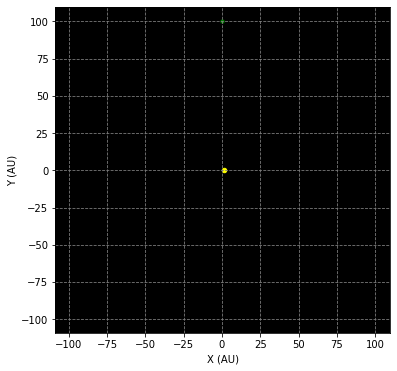

In [13]:
#sets number of frames for simulation showing the planet orbiting around the star 
frames = np.linspace(0,10000-50, 100, dtype = 'int')

#creating an animation of one orbit of the single planet system
fig = plt.figure(figsize = (6,6))
camera = Camera(fig)
ax = plt.axes()
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.grid(color = 'gray', linestyle= '--')
ax.set_facecolor("black")

for i in frames:
    plt.scatter(sim_data[0][0,i]/AU, sim_data[1][0,i]/AU, color = 'green', s = 10)
    plt.scatter(sim_data[0][1,i]/AU, sim_data[1][1,i]/AU, color = 'yellow', s = 20)
    #snaps image of plot at each frame
    camera.snap()

#creates the animation and saves it as a gif
animation = camera.animate()
animation.save('SinglePlanetSystem.gif', writer = 'imagemagick')

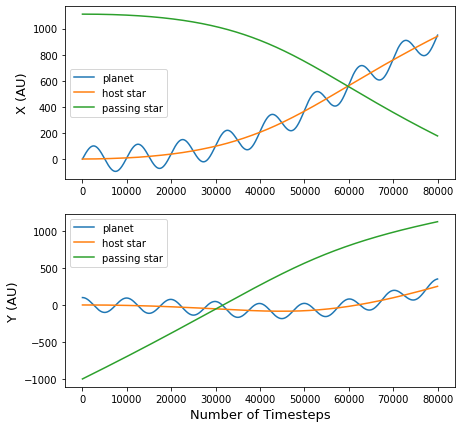

In [14]:
#plotting and labelling the positions of the single planet system and passing star over time

fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(7)

axs[0].plot(sim_data2[0][0,:]/AU, label = 'planet')
axs[0].plot(sim_data2[0][1,:]/AU, label = 'host star')
axs[0].plot(sim_data2[0][2,:]/AU,label = 'passing star')

axs[1].plot(sim_data2[1][0,:]/AU, label = 'planet')
axs[1].plot(sim_data2[1][1,:]/AU, label = 'host star')
axs[1].plot(sim_data2[1][2,:]/AU, label = 'passing star')

axs[0].legend()
axs[0].set_ylabel("X (AU)", fontsize = "13")
axs[1].set_ylabel("Y (AU)", fontsize = "13")
axs[1].set_xlabel("Number of Timesteps", fontsize = "13")
axs[1].legend()

plt.savefig("PlanetSystemDisrupted.pdf", bbox_inches = 'tight')
plt.show()

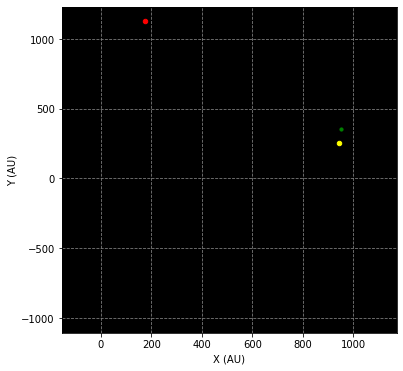

In [15]:
#sets number of frames for simulation 
frames = np.linspace(0,80000-1, 100, dtype = 'int')

#creating an animation of the evolution of the single planet system disrupted by another star
fig = plt.figure(figsize = (6,6))
camera = Camera(fig)
ax = plt.axes()
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.grid(color = 'gray', linestyle= '--')
ax.set_facecolor("black")

for i in frames:
    plt.scatter(sim_data2[0][0,i]/AU, sim_data2[1][0,i]/AU, color = 'green', s = 10)
    plt.scatter(sim_data2[0][1,i]/AU, sim_data2[1][1,i]/AU, color = 'yellow', s = 20)
    plt.scatter(sim_data2[0][2,i]/AU, sim_data2[1][2,i]/AU, s = 20, color = 'red')
    #snaps image of plot at each frame
    camera.snap()

#creates the animation and saves it as a gif
animation = camera.animate()
animation.save('PlanetSystemDisrupted.gif', writer = 'imagemagick')

In [16]:
#Changes the initial position value for the third body star before integration scheme so that it starts 
#a bit closer to the planetary system

#x and y coordinates 
x_star = 9.35e+15 #cm
y_star = -1.496e+16 #cm

#star's mass 
m_star = M_star

#initial position vector
r_star = np.array([x_star, y_star]) #cm

#some initial energy changes 

#potential energy between planet and star 2
Ui_planet2 = G*m_star*M_J / ((np.linalg.norm(r_star - r0))**2)

#potential energy between star 1 and star 2
Ui_stars = G*M_star*m_star / (np.linalg.norm(r_star)**2)

#total intial energy for the three body system
Ei_total2 = KEi_planet + KEi_star1 + KEi_star2 + Ui_planet + Ui_planet2 + Ui_stars

In [17]:
#resets the initial value list for position
r_all = [r0,r1,r_star]

In [18]:
#uses 4th order hermite integration scheme to simulate the evolution of a
#single planet system that is subject to an external perturbation due to a passing star that disrupts the 
#planet's orbit

sim_data3 = Nbody_Hermite(m_all, r_all, v_all, a_all, da_all, dt, 8*T, 3)

In [19]:
#Final energy calculation for the single planet system that is subject to an external perturbation 
#due to a passing star that affects it's orbit 

#planet - star 1 final distance
rf_planet_star1  = np.sqrt((sim_data3[0][0,-1] - sim_data3[0][1,-1])**2 + (sim_data3[1][0,-1] - sim_data3[1][1,-1])**2)

#planet - star 2 final distance 
rf_planet_star2 = np.sqrt((sim_data3[0][0,-1] - sim_data3[0][2,-1])**2 + (sim_data3[1][0,-1] - sim_data3[1][2,-1])**2)

#star 1- star 2 final distance 
rf_star1_star2 = np.sqrt((sim_data3[0][1,-1] - sim_data3[0][2,-1])**2 + (sim_data3[1][1,-1] - sim_data3[1][2,-1])**2)

#planet final velocity squared
v2_planet = sim_data3[2][0,-1]**2 + sim_data3[3][0,-1]**2

#star 1 final velocity squared
v2_star1 = sim_data3[2][1,-1]**2 + sim_data3[3][1,-1]**2

#star 2 final velocity squared
v2_star2 = sim_data3[2][2,-1]**2 + sim_data3[3][2,-1]**2

#kinetic energy of planet 
KEf_planet = (1/2)*M_J*(v2_planet)

#kinetic energy of star 1:
KEf_star1 = (1/2)*M_star*(v2_star1)

#kinetic energy of star 2: 
KEf_star2 = (1/2)*m_star*(v2_star2)

#potential energy between planet and star 1
Uf_planet = G*M_star*M_J / ((rf_planet_star1)**2)

#potential energy between planet and star 2
Uf_planet2 = G*m_star*M_J / ((rf_planet_star2)**2)

#potential energy between star 1 and star 2
Uf_stars = G*M_star*m_star / ((rf_star1_star2)**2)

#total final energy 
Ef_total2 = KEf_planet + KEf_star1 + KEf_star2 + Uf_planet + Uf_planet2 + Uf_stars

#prints initial and final energy
print("Initial Energy:", Ei_total2, "ergs")
print("Final Energy:", Ef_total2, "ergs")

#calculatng and printing the percent difference between the energies
diff = (abs(Ei_total2 - Ef_total2) / ((Ei_total2 + Ef_total2)/2))*100
print("Percent difference:", diff, "%")

#they conserved to a reasonable degree is their difference is within: 
e = 25 #%

#checking if energy is conserved reasonably 
if diff < e:
    print("Energy is conserved.")
else: 
    print("Energy is not conserved.")

Initial Energy: 5.042333990641711e+42 ergs
Final Energy: 4.115803840399824e+42 ergs
Percent difference: 20.234029391901274 %
Energy is conserved.


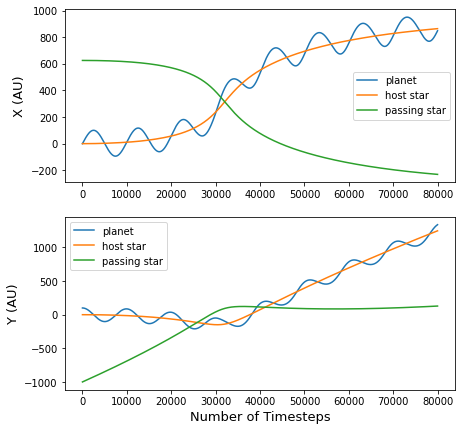

In [20]:
#plotting the positions of the single planet system and close passing star over time

fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(7)

axs[0].plot(sim_data3[0][0,:]/AU, label = 'planet')
axs[0].plot(sim_data3[0][1,:]/AU, label = 'host star')
axs[0].plot(sim_data3[0][2,:]/AU,label = 'passing star')

axs[1].plot(sim_data3[1][0,:]/AU, label = 'planet')
axs[1].plot(sim_data3[1][1,:]/AU, label = 'host star')
axs[1].plot(sim_data3[1][2,:]/AU, label = 'passing star')

axs[0].legend()
axs[0].set_ylabel("X (AU)", fontsize = "13")
axs[1].set_ylabel("Y (AU)", fontsize = "13")
axs[1].set_xlabel("Number of Timesteps", fontsize = "13")
axs[1].legend()

plt.savefig("PlanetSystemDisrupted2.pdf", bbox_inches = 'tight')
plt.show()

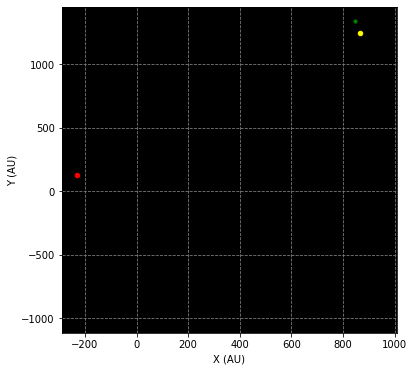

In [21]:
#sets number of frames for simulation 
frames = np.linspace(0,80000-1, 100, dtype = 'int')

#creating an animation of the evolution of the single planet system whose orbit is disrupted by another star
fig = plt.figure(figsize = (6,6))
camera = Camera(fig)
ax = plt.axes()
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.grid(color = 'gray', linestyle= '--')
ax.set_facecolor("black")

for i in frames:
    plt.scatter(sim_data3[0][0,i]/AU, sim_data3[1][0,i]/AU, color = 'green', s = 10)
    plt.scatter(sim_data3[0][1,i]/AU, sim_data3[1][1,i]/AU, color = 'yellow', s = 20)
    plt.scatter(sim_data3[0][2,i]/AU, sim_data3[1][2,i]/AU, s = 20, color = 'red')
    #snaps image of plot at each frame
    camera.snap()

#creates the animation and saves it as a gif
animation = camera.animate()
animation.save('PlanetSystemDisrupted2.gif', writer = 'imagemagick')